1. Import Library

In [ ]:
%pip install pyvi
from pyvi import ViTokenizer

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import regex as re
from gensim.parsing.preprocessing import strip_numeric
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cdist
from itertools import chain
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import v_measure_score

In [ ]:
def remove_punctuation(document):
    for letter in document:
        if letter in string.punctuation:
            document = document.replace(letter, "")
    return document
def remove_punctuation(document):
    return re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',document)
def remove_blank(document):
    return re.sub(r'\s+', ' ', document).strip()
def text_preprocess(document):
    document = strip_numeric(document)
    document = ViTokenizer.tokenize(document)
    document = document.lower()
    document = remove_punctuation(document)
    document = remove_blank(document)
    return document

In [ ]:
label = {0: 'am_nhac', 1: 'am_thuc', 2: 'bat_dong_san', 3: 'bong_da', 4: 'chung_khoan', 5: 'du_hoc', 6: 'du_lich', 7: 'gia_dinh', 8: 'hinh_su', 9: 'thoi_trang'}
number_of_label = 10
my_list = []
my_labels = []
for i in range(number_of_label):
  filename = label.get(i) + '_train.csv'
  df =  pd.read_csv(filename, delimiter = '\n', header = None ,encoding = 'UTF-16').values
  for j in range(df.shape[0]):
    df[j, :][0] = text_preprocess(df[j, :][0])
    my_list.append(df[j, :][0])
    my_labels.append(i)

In [ ]:
my_list = pd.read_csv("my_list.csv", header=None).values.flatten()
my_labels = pd.read_csv("my_labels.csv", header=None).values.flatten()

In [ ]:
my_labels = pd.read_csv("my_labels.csv", header=None).values.flatten()
my_labels.shape

(1943,)

2. Feature Extraction

In [ ]:
vectorizer = CountVectorizer()

#Remove word starts with '_' or ends with '_'
each_word_my_list = [i.split(" ") for i in my_list]
for sentence in each_word_my_list:
  for word in sentence:
    if word[0] == '_' or word[-1] == '_':
      sentence.remove(word)
my_list = [" ".join(sentence) for sentence in each_word_my_list]
X_count = np.array(vectorizer.fit_transform(my_list).toarray()) #count matrix
word_dict = np.array(vectorizer.get_feature_names()) #bag of word

In [ ]:
print(word_dict.shape)
print(X_count.shape)

(27133,)
(1943, 27133)


In [ ]:
def cal_tfidf(X):
    tf = X/np.sum(X, axis = 1, keepdims = True)
    N = X.shape[0]
    d = np.count_nonzero(X, axis = 0, keepdims = True)
    idf = np.log(N/(d + 1))
    return tf*idf
X_tfidf = cal_tfidf(X_count)

In [ ]:
#X ma trận N * d
def kmeans_init_centroids(X, k):
  #Chọn k hàng bất kì trong ma trận X
  # k * d
  return X[np.random.choice(X.shape[0], k, replace = False)]

def kmeans_assign_labels(X, centroids, metric):
  #Tính khoảng cách giữa từng điểm vs centroids
  D = cdist(X, centroids, metric = metric)
  #return index của điểm gần với centroids nhất
  #(d,) nhận các giá trị từ (0, 1, ...k-1)
  return np.argmin(D, axis = 1)

def has_converged(centroids, new_centroids):
  return (set([tuple(a) for a in centroids]) == set([tuple(a) for a in new_centroids]))

def kmeans_update_centroids(X, labels, K):
  centroids = np.zeros((K, X.shape[1]))
  for k in range(K):
    #Lấy các điểm có label = k
    Xk = X[labels == k, :]
    #centroid thứ k lấy trung bình cộng
    centroids[k, :] = np.mean(Xk, axis = 0)
  return centroids

def cal_inertia(X, labels, K, centroids, metric):
  inertia = 0
  for k in range(K):
    Xk = X[labels == k, :]
    sum =  np.sum(cdist(Xk, centroids[k:k+1, :], metric = metric), axis = 0)
    inertia += np.sum(sum ** 2)
  return inertia

def kmeans(X, K, metric):
  centroids = kmeans_init_centroids(X, K)  #k * d
  labels = []
  i = 0
  while True:
    labels = kmeans_assign_labels(X, centroids, metric)
    new_centroids = kmeans_update_centroids(X, labels, K)
    if has_converged(centroids, new_centroids) or i == 500:
      break
    centroids = new_centroids
    i += 1
  return centroids, labels

2.1 Loại bỏ bằng việc quan sát số lần xuất hiện

In [ ]:
word_freq = np.sum(X_count, axis = 0)     #count number of times each words in BoW appeared
word_freq_sort = np.sort(word_freq)            
word_freq_index = np.argsort(word_freq)
word_freq_dict = [(i, np.count_nonzero(word_freq == i)) for i in np.unique(word_freq)]

In [ ]:
word_freq

array([ 3,  1,  1, ...,  1,  1, 18], dtype=int64)

In [ ]:
word_freq_dict[:10]

[(1, 11616),
 (2, 3803),
 (3, 1990),
 (4, 1288),
 (5, 936),
 (6, 720),
 (7, 540),
 (8, 464),
 (9, 355),
 (10, 322)]

In [ ]:
word_freq_sort

array([    1,     1,     1, ...,  9631, 11207, 11428], dtype=int64)

In [ ]:
word_freq_index

array([19864,  9757, 20739, ..., 11081, 23920,  4790], dtype=int64)

2.1.1. Loại bỏ các từ xuất hiện ít hơn 5 lần

In [ ]:
word_less_than_5 = [i for i in range(len(word_freq)) if word_freq[i] < 5][::-1]
len(word_less_than_5)

18697

In [ ]:
X_train_less5 = np.copy(X_tfidf)
word_dict_less5 = np.copy(word_dict)
X_train_less5 = np.delete(X_train_less5, word_less_than_5, 1)
word_dict_less5 = np.delete(word_dict_less5, word_less_than_5)

In [ ]:
K = range(2, 20)

inertias = []
silhouette_avg = []
centroids_list = []
labels_list = []
for k in K:
  centroids, labels = kmeans(X_train_less5, k, 'cosine')
  centroids_list.append(centroids)
  labels_list.append(labels)
  inertia = cal_inertia(X_train_less5, labels, k, centroids, 'cosine')
  inertias.append(inertia)

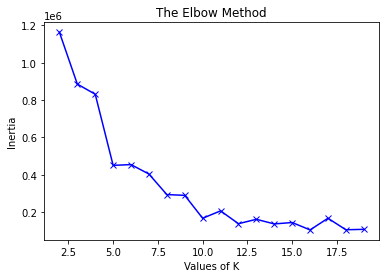

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

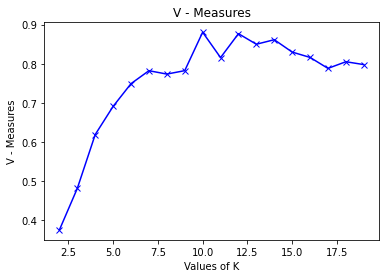

In [ ]:
V = [v_measure_score(my_labels, labels_list[i]) for i in range(18)]
plt.plot(K, V, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('V - Measures')
plt.title('V - Measures')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_less5, np.array(my_labels).reshape(-1,), test_size=0.2)
model1 = BernoulliNB()
model1.fit(X_train, y_train)
model2 = LogisticRegression()
model2.fit(X_train, y_train)
model3 = SVC()
model3.fit(X_train, y_train)
y_predict1 = model1.predict(X_test)
y_predict2 = model2.predict(X_test)
y_predict3 = model3.predict(X_test)

In [ ]:
print("BernoulliNB ")
print(classification_report(y_test,y_predict1, zero_division=1))
print("LR ")
print(classification_report(y_test,y_predict2, zero_division=1))
print("SVM ")
print(classification_report(y_test,y_predict3, zero_division=1))

BernoulliNB 
              precision    recall  f1-score   support

           0       0.97      0.71      0.82        45
           1       0.85      0.95      0.90        37
           2       0.79      0.82      0.81        38
           3       1.00      0.81      0.89        36
           4       0.70      0.94      0.81        33
           5       0.76      0.96      0.85        49
           6       0.83      0.81      0.82        43
           7       0.96      0.93      0.94        27
           8       0.88      1.00      0.94        29
           9       0.95      0.73      0.83        52

    accuracy                           0.85       389
   macro avg       0.87      0.86      0.86       389
weighted avg       0.87      0.85      0.85       389

LR 
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        45
           1       1.00      0.92      0.96        37
           2       0.97      1.00      0.99        38
       

2.1.2. Loại các từ stop word

In [ ]:
my_list_stop_word = pd.read_csv("stop_word.csv").values.flatten()
my_list_stop_word = ["_".join(my_list_stop_word[i].split(" ")) for i in range(len(my_list_stop_word))]
my_list_stop_word[:10]

['a_lô',
 'ai',
 'ai_ai',
 'ai_nấy',
 'alô',
 'amen',
 'anh',
 'bao_giờ',
 'bao_lâu',
 'bao_nhiêu']

In [ ]:
word_stop = [i for i in range(len(word_dict)) if word_dict[i] in my_list_stop_word][::-1]
X_train_stop = np.copy(X_tfidf)
word_dict_stop = np.copy(word_dict)
X_train_stop = np.delete(X_train_stop, word_stop, 1)
word_dict_stop = np.delete(word_dict_stop, word_stop)

In [ ]:
K = range(2, 20, 2)

inertias = []
silhouette_avg = []
centroids_list = []
labels_list = []
for k in K:
  centroids, labels = kmeans(X_train_stop, k, 'cosine')
  centroids_list.append(centroids)
  labels_list.append(labels)
  inertia = cal_inertia(X_train_stop, labels, k, centroids, 'cosine')
  inertias.append(inertia)

In [ ]:
len(labels_list)

9

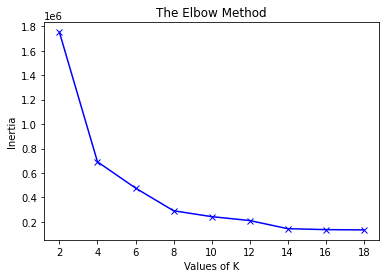

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

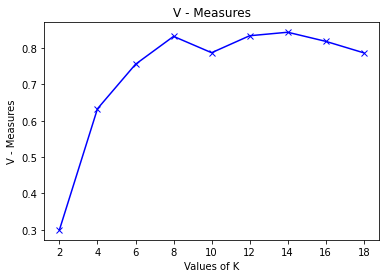

In [ ]:
V = [v_measure_score(my_labels, labels_list[int(i/2)-1]) for i in range(2,20,2)]
plt.plot(K, V, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('V - Measures')
plt.title('V - Measures')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_stop, np.array(my_labels).reshape(-1,), test_size=0.2)
model1 = BernoulliNB()
model1.fit(X_train, y_train)
model2 = LogisticRegression()
model2.fit(X_train, y_train)
model3 = SVC()
model3.fit(X_train, y_train)
y_predict1 = model1.predict(X_test)
y_predict2 = model2.predict(X_test)
y_predict3 = model3.predict(X_test)
print("BernoulliNB ")
print(classification_report(y_test,y_predict1, zero_division=1))
print("LR ")
print(classification_report(y_test,y_predict2, zero_division=1))
print("SVM ")
print(classification_report(y_test,y_predict3, zero_division=1))

BernoulliNB 
              precision    recall  f1-score   support

           0       0.82      0.78      0.79        40
           1       0.97      0.95      0.96        40
           2       0.97      0.74      0.84        38
           3       1.00      0.86      0.92        43
           4       0.77      0.98      0.86        48
           5       0.66      1.00      0.80        45
           6       0.86      0.86      0.86        35
           7       1.00      0.56      0.72        32
           8       1.00      0.96      0.98        26
           9       0.79      0.74      0.77        42

    accuracy                           0.85       389
   macro avg       0.88      0.84      0.85       389
weighted avg       0.87      0.85      0.85       389

LR 
              precision    recall  f1-score   support

           0       0.88      0.95      0.92        40
           1       1.00      0.85      0.92        40
           2       1.00      1.00      1.00        38
       

2.1.3. Loại 

In [ ]:
A1 = word_freq_index[word_freq == 1]
A2 = word_freq_index[word_freq == 2]
A3 = word_freq_index[word_freq == 9553]
A4 = word_freq_index[word_freq == 9631]
A5 = word_freq_index[word_freq == 11207]
A6 = word_freq_index[word_freq == 11428]
list_index = np.sort(np.array(list(chain(A1, A2, A3, A4, A5, A6))))[::-1]

In [ ]:
X_train_count = np.copy(X_tfidf)
word_dict_count = np.copy(word_dict)
X_train_count = np.delete(X_train_count, list_index, 1)
word_dict_count = np.delete(word_dict_count, list_index)

In [ ]:
X_train_count.shape

(1943, 11711)

In [ ]:
K = range(2, 20)

inertias = []
silhouette_avg = []
centroids_list = []
labels_list = []
for k in K:
  centroids, labels = kmeans(X_train_count, k, 'cosine')
  centroids_list.append(centroids)
  labels_list.append(labels)
  inertia = cal_inertia(X_train_count, labels, k, centroids, 'cosine')
  inertias.append(inertia)

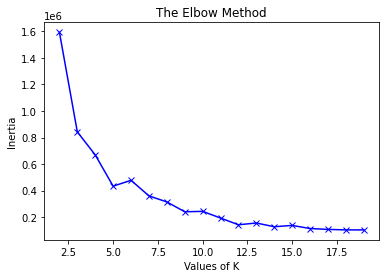

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

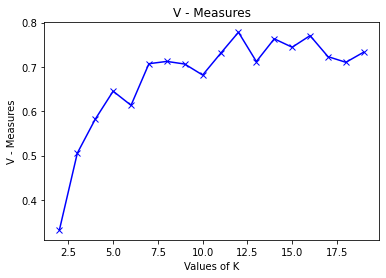

In [ ]:
V = [v_measure_score(my_labels, labels_list[i]) for i in range(18)]
plt.plot(K, V, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('V - Measures')
plt.title('V - Measures')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_count, np.array(my_labels).reshape(-1,), test_size=0.2)
model1 = BernoulliNB()
model1.fit(X_train, y_train)
model2 = LogisticRegression()
model2.fit(X_train, y_train)
model3 = SVC()
model3.fit(X_train, y_train)
y_predict1 = model1.predict(X_test)
y_predict2 = model2.predict(X_test)
y_predict3 = model3.predict(X_test)
print("BernoulliNB ")
print(classification_report(y_test,y_predict1, zero_division=1))
print("LR ")
print(classification_report(y_test,y_predict2, zero_division=1))
print("SVM ")
print(classification_report(y_test,y_predict3, zero_division=1))

BernoulliNB 
              precision    recall  f1-score   support

           0       0.78      0.76      0.77        37
           1       0.98      0.98      0.98        46
           2       0.91      0.67      0.77        45
           3       1.00      0.77      0.87        39
           4       0.65      1.00      0.79        34
           5       0.49      1.00      0.66        35
           6       0.91      0.65      0.76        48
           7       0.95      0.57      0.71        37
           8       0.93      0.93      0.93        29
           9       0.78      0.72      0.75        39

    accuracy                           0.79       389
   macro avg       0.84      0.80      0.80       389
weighted avg       0.85      0.79      0.80       389

LR 
              precision    recall  f1-score   support

           0       0.70      0.86      0.77        37
           1       1.00      0.87      0.93        46
           2       1.00      0.80      0.89        45
       

2.1.4. Giữ nguyên

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, np.array(my_labels).reshape(-1,), test_size=0.2)
model1 = BernoulliNB()
model1.fit(X_train, y_train)
model2 = LogisticRegression()
model2.fit(X_train, y_train)
model3 = SVC()
model3.fit(X_train, y_train)
y_predict1 = model1.predict(X_test)
y_predict2 = model2.predict(X_test)
y_predict3 = model3.predict(X_test)
print("BernoulliNB ")
print(classification_report(y_test,y_predict1, zero_division=1))
print("LR ")
print(classification_report(y_test,y_predict2, zero_division=1))
print("SVM ")
print(classification_report(y_test,y_predict3, zero_division=1))

BernoulliNB 
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        36
           1       0.86      0.94      0.90        34
           2       0.97      0.75      0.85        48
           3       1.00      0.80      0.89        44
           4       0.72      0.98      0.83        42
           5       0.63      0.97      0.77        39
           6       0.90      0.86      0.88        42
           7       1.00      0.59      0.75        32
           8       1.00      0.87      0.93        30
           9       0.80      0.76      0.78        42

    accuracy                           0.84       389
   macro avg       0.87      0.84      0.84       389
weighted avg       0.87      0.84      0.84       389

LR 
              precision    recall  f1-score   support

           0       0.70      0.97      0.81        36
           1       1.00      0.97      0.99        34
           2       1.00      1.00      1.00        48
       

In [ ]:
K = range(2, 20)

inertias = []
silhouette_avg = []
centroids_list = []
labels_list = []
for k in K:
  centroids, labels = kmeans(X_tfidf, k, 'cosine')
  centroids_list.append(centroids)
  labels_list.append(labels)
  inertia = cal_inertia(X_tfidf, labels, k, centroids, 'cosine')
  inertias.append(inertia)

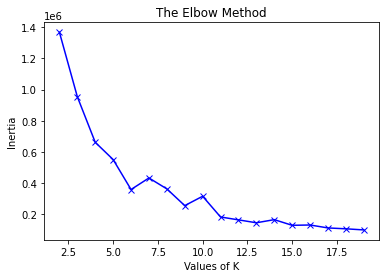

In [ ]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

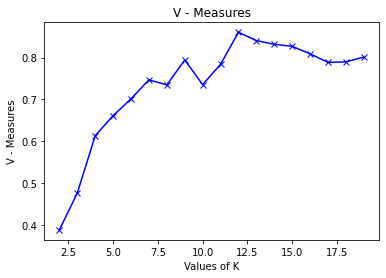

In [ ]:
V = [v_measure_score(my_labels, labels_list[i]) for i in range(18)]
plt.plot(K, V, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('V - Measures')
plt.title('V - Measures')
plt.show()